# Near-Miss Detection — Local Test Notebook

> **Local dev variant** of `near_miss_detection_demo.ipynb`  
> Assumes the environment is already set up. Run `pip install -r requirements.txt` once if needed.

**Differences from the Colab notebook:**
- No `pip install` cell
- No video download — expects `data/traffic_video.mp4` to already exist
- `MAX_FRAMES` cap for fast iteration (set to `None` to process full video)
- Smaller defaults (stride=4, input_size=320) for speed
- Inline matplotlib (no Agg)
- Annotated video and ONNX benchmark are **off by default** (toggle via flags)

---
## Config — Edit These Before Running
All tunable parameters are gathered here so you don't need to scroll through the notebook.

In [1]:
import os

# ── Paths ─────────────────────────────────────────────────────────────────
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
VIDEO_PATH   = os.path.join(PROJECT_ROOT, 'data', 'traffic_video.mp4')
# VIDEO_PATH   = os.path.join(PROJECT_ROOT, 'data', 'traffic_video_2.mp4')
OUTPUT_DIR   = os.path.join(PROJECT_ROOT, 'outputs', 'local_test')

# ── Model selection ───────────────────────────────────────────────────────
# Detection models (UltralyticsDetector / SAHIDetector):
#   YOLO26               : yolo26n  yolo26s  yolo26l  yolo26x
#   YOLO11               : yolo11n  yolo11s  yolo11l  yolo11x
#   YOLOv8               : yolov8n  yolov8s  yolov8l  yolov8x
#   RT-DETR (transformer): rtdetr-l  rtdetr-x
#
# Segmentation models (UltralyticsSegDetector — adds 'contour' to each det):
#   YOLO26-seg: yolo26n-seg  yolo26s-seg  yolo26l-seg  yolo26x-seg
#   YOLO11-seg: yolo11n-seg  yolo11s-seg  yolo11l-seg
#   YOLOv8-seg: yolov8n-seg  yolov8s-seg  yolov8l-seg
#
# Backends:
#   'ultralytics'     — standard detection (default)
#   'ultralytics-seg' — segmentation; use a *-seg model above
#   'sahi'            — sliced inference, best recall for small/far objects
MODEL_NAME   = 'yolo26x.pt'
# MODEL_NAME   = 'rtdetr-l.pt'
BACKEND      = 'ultralytics'

# ── Speed controls ────────────────────────────────────────────────────────
MAX_FRAMES   = 300    # Process only first N frames. Set to None for full video.
FRAME_STRIDE = 1      # Sample every N-th frame (higher = faster, less smooth tracking)
INPUT_SIZE   = 640    # YOLO inference resolution (320 = fast, 640 = accurate, 1280 = max)

# ── Detection thresholds ──────────────────────────────────────────────────
# Float: same threshold for all classes.
# Dict:  per-class thresholds, e.g. {"vehicle": 0.4, "pedestrian": 0.3}
CONF_THRESH  = 0.35
CONF_THRESH = {"vehicle": 0.4, "pedestrian": 0.7}   # ← uncomment for per-class

NMS_IOU      = 0.45  
NMS_IOU      = None

# ── Tracking ──────────────────────────────────────────────────────────────
MAX_DISTANCE    = 200
MAX_DISAPPEARED = 15

# ── Near-miss thresholds ──────────────────────────────────────────────────
PROXIMITY_PX    = 120
TTC_THRESHOLD   = 2.5
DEBOUNCE_FRAMES = 20
FILTERS_ENABLED = True

# ── Output flags (slow steps, off by default) ─────────────────────────────
WRITE_VIDEO      = False   # Write annotated MP4 (slow)
RUN_BENCHMARK    = False   # Run ONNX export + FPS benchmark (slow)

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Video   : {VIDEO_PATH}')
print(f'Outputs : {OUTPUT_DIR}')
print(f'Model   : {MODEL_NAME}  backend={BACKEND}')
print(f'Conf    : {CONF_THRESH}  NMS IoU: {NMS_IOU}')
print(f'Max frames to process: {MAX_FRAMES}')


Video   : /Users/mina.essam/Downloads/tatweer/data/traffic_video.mp4
Outputs : /Users/mina.essam/Downloads/tatweer/outputs/local_test
Model   : yolo26x.pt  backend=ultralytics
Conf    : {'vehicle': 0.4, 'pedestrian': 0.7}  NMS IoU: None
Max frames to process: 300


---
## Imports

In [2]:
import sys, time, math

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from IPython.display import display

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

from src.video_utils import get_video_metadata, sample_frames, frame_generator
from src.detector   import create_detector, draw_detections
from src.tracker    import CentroidTracker
from src.near_miss  import NearMissDetector, NearMissDetectorV11
from src.visualizer import (
    annotate_frame, create_annotated_video,
    plot_timeline, plot_risk_distribution,
    plot_heatmap, plot_frequency,
    generate_html_report,
)

print('Imports OK.')


Imports OK.


---
## 1. Video Metadata

In [3]:
assert os.path.exists(VIDEO_PATH), (
    f'Video not found: {VIDEO_PATH}\n'
    'Run the Colab notebook first (Section 2) or download manually with yt-dlp.'
)

meta = get_video_metadata(VIDEO_PATH)
EFFECTIVE_FPS = meta['fps'] / FRAME_STRIDE

print(f"Resolution : {meta['width']} × {meta['height']}")
print(f"FPS        : {meta['fps']:.2f}  (effective after stride={FRAME_STRIDE}: {EFFECTIVE_FPS:.2f})")
print(f"Frames     : {meta['frame_count']}")

dur = meta['duration_sec']
if MAX_FRAMES is not None:
    test_dur = (MAX_FRAMES * FRAME_STRIDE) / meta['fps']
    print(f"Duration   : {dur:.1f}s total — testing first ~{test_dur:.1f}s ({MAX_FRAMES} processed frames)")
else:
    print(f"Duration   : {dur:.1f}s (full video)")

Resolution : 1280 × 720
FPS        : 20.00  (effective after stride=1: 20.00)
Frames     : 458
Duration   : 22.9s total — testing first ~15.0s (300 processed frames)


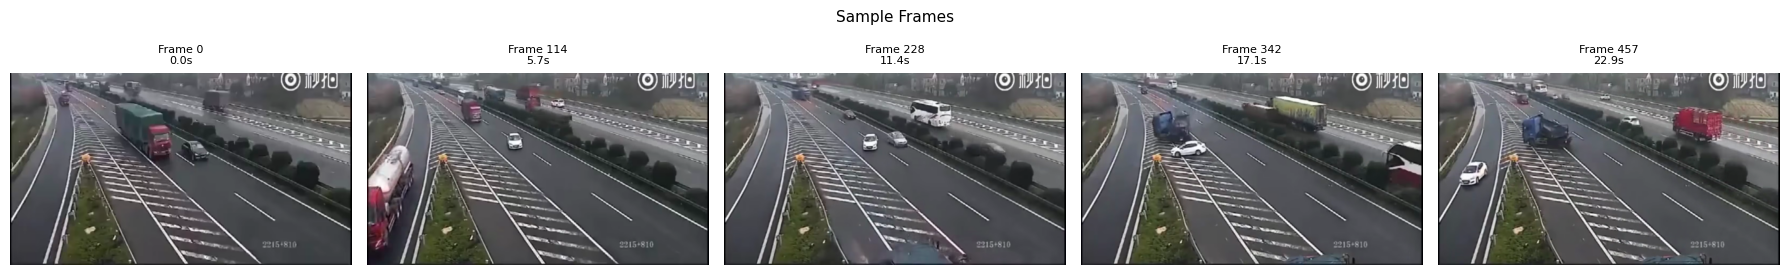

In [4]:
frames = sample_frames(VIDEO_PATH, n=5)

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax, (idx, frame) in zip(axes, frames):
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Frame {idx}\n{idx/meta["fps"]:.1f}s', fontsize=8)
    ax.axis('off')
plt.suptitle('Sample Frames', fontsize=11)
plt.tight_layout()
plt.show()

---
## 2. Detector Smoke Test
Run detection on 6 frames and display results.

In [5]:
detector = create_detector(
    model_name=MODEL_NAME,
    backend=BACKEND,
    conf=CONF_THRESH,
    nms_iou=NMS_IOU,
    input_size=INPUT_SIZE,
)
print('Detector ready.')


Loading yolo26x.pt on cpu ...
Model ready.
Detector ready.


In [ ]:
preview = sample_frames(VIDEO_PATH, n=6)

fig, axes = plt.subplots(2, 3, figsize=(16*2, 7*2))
for ax, (idx, frame) in zip(axes.flatten(), preview):
    dets = detector.detect(frame)
    ann  = draw_detections(frame, dets)
    ax.imshow(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Frame {idx} — {len(dets)} detections', fontsize=9)
    ax.axis('off')

plt.suptitle(f'Detection Preview (input_size={INPUT_SIZE}, conf≥{CONF_THRESH})', fontsize=11)
plt.tight_layout()
plt.show()

print(f'Avg inference: {detector.avg_inference_ms:.1f} ms/frame')
detector.print_stats()
detector.reset_timing()

---
## 2b. Model Comparison
Run detection on the same frames with multiple models and compare latency + detection count.
Skip this cell to save time — it's purely for experimentation.

In [ ]:
# ── Model comparison — edit COMPARE_MODELS to taste ─────────────────────
# YOLO26: best for this project (CPU-optimised, NMS-free, best small-object mAP)
# YOLO12: GPU-optimised, no published CPU benchmark, lower mAP than YOLO26 at same size
# RT-DETR: transformer, strong on small objects but very slow on CPU
# *-seg:  segmentation models — same mAP, adds contour output for near-miss area logic
#
# Model           Params  mAP(50-95)  CPU(ms)
# yolo26n.pt       2.4M     40.9       38.9   ← fastest
# yolo26s.pt       9.5M     48.6       87.2
# yolo26l.pt      24.8M     55.0      286.2   ← recommended
# yolo26x.pt      55.7M     57.5      525.8   ← max accuracy
# yolo12l.pt      26.4M     53.7        —     ← worse mAP than yolo26l, skip on CPU
COMPARE_MODELS = [
    # {'model_name': 'yolo26n.pt',       'backend': 'ultralytics', 'input_size': 640},
    {'model_name': 'yolo26l.pt',       'backend': 'ultralytics', 'input_size': 640},
    {'model_name': 'yolo26x.pt',       'backend': 'ultralytics', 'input_size': 640},
    # {'model_name': 'yolo26l-seg.pt',   'backend': 'ultralytics-seg', 'input_size': 640},
    # {'model_name': 'yolo12l.pt',       'backend': 'ultralytics', 'input_size': 640},
    # {'model_name': 'yolo11l.pt',       'backend': 'ultralytics', 'input_size': 640},
    {'model_name': 'rtdetr-l.pt',      'backend': 'ultralytics', 'input_size': 640},
    # {'model_name': 'yolo26l.pt',       'backend': 'sahi', 'slice_height': 512},
]
N_COMPARE_FRAMES = 20

sample_imgs = [f for _, f in sample_frames(VIDEO_PATH, n=N_COMPARE_FRAMES)]
rows = []

for cfg in COMPARE_MODELS:
    name = cfg['model_name']
    print(f'Testing {name} ...')
    try:
        d = create_detector(**cfg, conf=CONF_THRESH, nms_iou=NMS_IOU)
        total_dets = sum(len(d.detect(f)) for f in sample_imgs)
        s = d.stats
        rows.append({
            'model':          s['model_name'],
            'size_mb':        round(s['model_size_mb'], 1),
            'avg_ms':         s['avg_latency_ms'],
            'p95_ms':         s['p95_latency_ms'],
            'throughput_fps': s['throughput_fps'],
            'total_dets':     total_dets,
            'dets_per_frame': round(total_dets / N_COMPARE_FRAMES, 1),
        })
    except Exception as e:
        print(f'  FAILED: {e}')
        rows.append({'model': name, 'size_mb': None, 'avg_ms': None,
                     'p95_ms': None, 'throughput_fps': None,
                     'total_dets': None, 'dets_per_frame': None})

cmp_df = pd.DataFrame(rows)
display(cmp_df)

if not cmp_df.dropna().empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    clean = cmp_df.dropna()
    labels = clean['model'].str.replace('.pt', '', regex=False)
    ax1.barh(labels, clean['avg_ms'], color='#3498db', label='avg')
    ax1.barh(labels, clean['p95_ms'], color='#e74c3c', alpha=0.5, label='p95')
    ax1.set_xlabel('Latency (ms/frame)'); ax1.set_title('Inference Latency')
    ax1.legend()
    ax2.barh(labels, clean['dets_per_frame'], color='#2ecc71')
    ax2.set_xlabel('Detections per frame'); ax2.set_title('Detection Count')
    plt.suptitle('Model Comparison', fontsize=13)
    plt.tight_layout()
    plt.show()


---
## 2c. Tracker Visualization
Run detection + tracking in isolation to inspect ID assignment, trajectory tails,
and ID stability. Tweak the config below and re-run the next two cells.

In [ ]:
import colorsys
from src.tracker import create_tracker

# ── Choose tracker ────────────────────────────────────────────────────────
# 'centroid'  — greedy L2 matching, no deps, fastest
# 'bytetrack' — 2-stage IoU + Kalman (pip install boxmot)
# 'botsort'   — IoU + Kalman + ReID appearance (pip install boxmot, ~20 MB weights)
TRACKER_NAME = 'bytetrack'

# ── min_hits: frames a new track must appear consecutively before output ──
# 1 → immediate (default, backward-compat)
# 2 → filters most single-frame noise
# 3 → conservative; only stable detections become tracks
MIN_HITS = 5

# ── Tracker params (only the active tracker's params are used) ────────────
CENTROID_PARAMS   = dict(max_disappeared=15, max_distance=200, min_hits=MIN_HITS)
BYTETRACK_PARAMS  = dict(track_thresh=0.25, track_buffer=90, match_thresh=0.8,
                          frame_rate=int(meta['fps']), min_hits=MIN_HITS)
BOTSORT_PARAMS    = dict(device='cpu', half=False, min_hits=MIN_HITS)

_tracker_params = {
    'centroid':  CENTROID_PARAMS,
    'bytetrack': BYTETRACK_PARAMS,
    'botsort':   BOTSORT_PARAMS,
}

# ── Run controls ──────────────────────────────────────────────────────────
VIZ_FRAMES   = 400          # number of processed frames to analyse
VIZ_STRIDE   = FRAME_STRIDE # reuse global stride (or set an independent value)

# ── Rendering ─────────────────────────────────────────────────────────────
TRAIL_LENGTH = 30           # centroid history points to draw per track
GRID_COLS    = 4            # columns in the output grid
GRID_EVERY   = 20           # capture 1 frame for the grid every N processed frames

# ── Video output ───────────────────────────────────────────────────────────
WRITE_TRACKER_VIDEO = True   # set True to write tracker_viz.mp4 alongside the run

# ─────────────────────────────────────────────────────────────────────────
def _id_color(obj_id: int):
    """Consistent BGR color per track ID via golden-ratio hue spread."""
    hue = (obj_id * 0.618033988749895) % 1.0
    r, g, b = colorsys.hsv_to_rgb(hue, 0.85, 0.92)
    return (int(b * 255), int(g * 255), int(r * 255))


def render_tracked(frame, tracked, trail_length=30):
    """Draw bounding boxes, track IDs, and faded trajectory tails."""
    out = frame.copy()
    for obj_id, obj in tracked.items():
        color = _id_color(obj_id)
        x1, y1, x2, y2 = obj['bbox']
        label = obj.get('label', obj['class'])

        # Bounding box
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

        # ID badge (filled rect + white text)
        tag = f"#{obj_id} {label}"
        (tw, th), _ = cv2.getTextSize(tag, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
        cv2.rectangle(out, (x1, y1 - th - 6), (x1 + tw + 4, y1), color, -1)
        cv2.putText(out, tag, (x1 + 2, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA)

        # Trajectory tail — fade older points
        traj = obj.get('trajectory', [])
        pts  = [(cx_, cy_) for (_, cx_, cy_) in traj[-trail_length:]]
        n    = len(pts)
        for i in range(1, n):
            alpha = i / n
            fade  = tuple(int(c * alpha) for c in color)
            cv2.circle(out, pts[i], max(1, int(2 * alpha)), fade, -1)

    # HUD
    cv2.putText(out, f"Active: {len(tracked)}", (8, 22),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(out, f"Active: {len(tracked)}", (8, 22),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return out




In [ ]:
# ── Instantiate ───────────────────────────────────────────────────────────
tracker_viz = create_tracker(TRACKER_NAME, **_tracker_params[TRACKER_NAME])
print(f"Tracker: {tracker_viz.tracker_name}")

grid_frames      = []
active_over_time = []
processed_viz    = 0

# Open VideoWriter if requested (same detection pass — no extra inference cost)
_writer = None
if WRITE_TRACKER_VIDEO:
    _cap_tmp = cv2.VideoCapture(VIDEO_PATH)
    _, _tmp_frame = _cap_tmp.read()
    _cap_tmp.release()
    _h, _w = _tmp_frame.shape[:2]
    _effective_fps = meta['fps'] / VIZ_STRIDE
    _video_out = os.path.join(OUTPUT_DIR, f'tracker_viz_{TRACKER_NAME}.mp4')
    _writer = cv2.VideoWriter(
        _video_out,
        cv2.VideoWriter_fourcc(*'mp4v'),
        _effective_fps,
        (_w, _h),
    )
    print(f"Writing video → {_video_out}  ({_w}×{_h} @ {_effective_fps:.1f} FPS)")

for frame_idx, frame in frame_generator(VIDEO_PATH, stride=VIZ_STRIDE):
    if processed_viz >= VIZ_FRAMES:
        break

    dets     = detector.detect(frame)
    tracked  = tracker_viz.update(dets, frame_idx, frame)
    rendered = render_tracked(frame, tracked, TRAIL_LENGTH)

    active_over_time.append((frame_idx, len(tracked)))

    if processed_viz % GRID_EVERY == 0:
        grid_frames.append((frame_idx, rendered))

    if _writer is not None:
        _writer.write(rendered)

    processed_viz += 1
    if processed_viz % 50 == 0:
        print(f"  {processed_viz}/{VIZ_FRAMES} frames ...", end='\r')

if _writer is not None:
    _writer.release()
    _size = os.path.getsize(_video_out) / 1e6
    print(f"\nVideo saved: {_video_out}  ({_size:.1f} MB, {processed_viz} frames)")

print(f"Processed : {processed_viz} frames  (stride={VIZ_STRIDE})")
print(f"Total IDs : {tracker_viz.total_ids_assigned}  |  "
      f"Still active: {tracker_viz.active_count()}")

# ── Active-object timeline ────────────────────────────────────────────────
fig_t, ax_t = plt.subplots(figsize=(12, 2.5))
tidxs, counts = zip(*active_over_time)
ax_t.fill_between(tidxs, counts, alpha=0.35, color='#3498db')
ax_t.plot(tidxs, counts, color='#3498db', linewidth=1)
ax_t.set_xlabel('Frame index'); ax_t.set_ylabel('Active tracks')
ax_t.set_title(f'{tracker_viz.tracker_name}  — Active Tracks Over Time')
ax_t.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Frame grid ────────────────────────────────────────────────────────────
n    = len(grid_frames)
rows = math.ceil(n / GRID_COLS)
fig, axes = plt.subplots(rows, GRID_COLS, figsize=(GRID_COLS * 5, rows * 3))
axes = np.array(axes).flatten()

for ax, (fidx, img) in zip(axes, grid_frames):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Frame {fidx}', fontsize=8)
    ax.axis('off')
for ax in axes[n:]:
    ax.set_visible(False)

plt.suptitle(f'Tracker Output — {tracker_viz.tracker_name}  (each color = unique ID)', fontsize=10)
plt.tight_layout(); plt.show()


In [ ]:
# ── Track length distribution ─────────────────────────────────────────────
traj_lens = [len(t) for t in tracker_viz.all_trajectories.values()]

if not traj_lens:
    print("No trajectories recorded.")
else:
    total    = len(traj_lens)
    mean_len = sum(traj_lens) / total
    median_l = sorted(traj_lens)[total // 2]
    short    = sum(1 for l in traj_lens if l <= 3)

    print(f"Total tracks  : {total}")
    print(f"Track length  — min: {min(traj_lens)}  max: {max(traj_lens)}  "
          f"mean: {mean_len:.1f}  median: {median_l}")
    print(f"Short (≤3 fr) : {short} / {total}  ({100*short/total:.1f}%)  "
          f"← likely noise or ID switches")

    fig, axes = plt.subplots(1, 2, figsize=(13, 3.5))

    # Histogram
    axes[0].hist(traj_lens, bins=30, color='#3498db', edgecolor='white')
    axes[0].axvline(mean_len, color='red',    linestyle='--', linewidth=1.2, label=f'mean={mean_len:.1f}')
    axes[0].axvline(median_l, color='orange', linestyle=':',  linewidth=1.2, label=f'median={median_l}')
    axes[0].set_xlabel('Track length (frames)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Track Length Distribution\n(short tracks = noise / ID switches)')
    axes[0].legend(fontsize=8)

    # Cumulative — what fraction of tracks lasted at least N frames?
    sorted_lens = sorted(traj_lens)
    ys = [sum(1 for l in traj_lens if l >= k) / total
          for k in range(1, max(traj_lens) + 1)]
    axes[1].plot(range(1, max(traj_lens) + 1), ys, color='#2ecc71')
    axes[1].axvline(5,  color='gray', linestyle=':', linewidth=1, label='5 frames')
    axes[1].axvline(10, color='gray', linestyle='--', linewidth=1, label='10 frames')
    axes[1].set_xlabel('Min track length (frames)')
    axes[1].set_ylabel('Fraction of tracks')
    axes[1].set_title('Track Survival Curve\n(% of tracks lasting ≥ N frames)')
    axes[1].legend(fontsize=8); axes[1].grid(alpha=0.3)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    plt.suptitle(
        f'Tracker Stability  '
      #   f'(max_dist={VIZ_MAX_DISTANCE}  max_disappeared={VIZ_MAX_DISAPPEARED}  '
        f'total_ids={tracker_viz.total_ids_assigned})',
        fontsize=10
    )
    plt.tight_layout(); plt.show()


---
## 2d. Tracker Comparison
Run all three trackers on the **same detections** (detection runs only once)
and display side-by-side frames + a summary stats table.

In [ ]:
import colorsys
from src.tracker import create_tracker

MIN_HITS = 5
CENTROID_PARAMS   = dict(max_disappeared=15, max_distance=200, min_hits=MIN_HITS)
BYTETRACK_PARAMS  = dict(track_thresh=0.25, track_buffer=90, match_thresh=0.8,
                          frame_rate=int(meta['fps']), min_hits=MIN_HITS)
BOTSORT_PARAMS    = dict(device='cpu', half=False, min_hits=MIN_HITS)


# ── Run controls ──────────────────────────────────────────────────────────
VIZ_FRAMES   = 400          # number of processed frames to analyse
VIZ_STRIDE   = FRAME_STRIDE # reuse global stride (or set an independent value)

# ── Rendering ─────────────────────────────────────────────────────────────
TRAIL_LENGTH = 30           # centroid history points to draw per track
GRID_COLS    = 4            # columns in the output grid
GRID_EVERY   = 20           # capture 1 frame for the grid every N processed frames

# ── Video output ───────────────────────────────────────────────────────────
WRITE_TRACKER_VIDEO = True   # set True to write tracker_viz.mp4 alongside the run



CMP_FRAMES  = 100   # frames to compare (keep small for speed)
CMP_STRIDE  = VIZ_STRIDE
CMP_SHOW    = [0, 25, 50, 75, 99]   # which processed-frame indices to display
WRITE_CMP_VIDEO = True   # write tracker_compare.mp4 (3 side-by-side trackers)




# ── 1. Collect detections once (expensive step) ───────────────────────────
print("Running detection for comparison frames ...")
cmp_det_cache = []   # [(frame_idx, frame, dets)]

for frame_idx, frame in frame_generator(VIDEO_PATH, stride=CMP_STRIDE):
    if len(cmp_det_cache) >= CMP_FRAMES:
        break
    dets = detector.detect(frame)
    cmp_det_cache.append((frame_idx, frame, dets))

print(f"  {len(cmp_det_cache)} frames cached.\n")

# ── 2. Instantiate all three trackers ────────────────────────────────────
cmp_trackers = {
    'centroid':  create_tracker('centroid',  **CENTROID_PARAMS),
    'bytetrack': create_tracker('bytetrack', **BYTETRACK_PARAMS),
    'botsort':   create_tracker('botsort',   **BOTSORT_PARAMS),
}
cmp_names    = list(cmp_trackers.keys())
cmp_active   = {n: [] for n in cmp_names}  # (frame_idx, n_active) per tracker
cmp_snapshots = {n: {} for n in cmp_names} # frame_idx → rendered frame

# ── 3. Replay detections through each tracker ─────────────────────────────
for n, tracker in cmp_trackers.items():
    print(f"Running {tracker.tracker_name} ...", end=' ')
    for proc_idx, (frame_idx, frame, dets) in enumerate(cmp_det_cache):
        tracked  = tracker.update(dets, frame_idx, frame)
        rendered = render_tracked(frame, tracked, TRAIL_LENGTH)
        cmp_active[n].append((frame_idx, len(tracked)))
        if proc_idx in CMP_SHOW:
            cmp_snapshots[n][proc_idx] = (frame_idx, rendered)
    print(f"done — {tracker.total_ids_assigned} IDs assigned")

# ── 4. Side-by-side frame grid ────────────────────────────────────────────
show_indices = sorted(set(CMP_SHOW) & set(cmp_snapshots[cmp_names[0]]))
n_rows = len(show_indices)
n_cols = len(cmp_names)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3.5))
if n_rows == 1:
    axes = axes[np.newaxis, :]

for row_i, proc_idx in enumerate(show_indices):
    for col_j, name in enumerate(cmp_names):
        ax = axes[row_i, col_j]
        if proc_idx in cmp_snapshots[name]:
            fidx, img = cmp_snapshots[name][proc_idx]
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(
                f"{name}  (frame {fidx})\n"
                f"IDs so far: {cmp_trackers[name].total_ids_assigned}",
                fontsize=8
            )
        ax.axis('off')

plt.suptitle('Tracker Comparison — same detections, different trackers', fontsize=11)
plt.tight_layout(); plt.show()

# ── 5. Active-tracks timeline overlay ────────────────────────────────────
colors = {'centroid': '#e74c3c', 'bytetrack': '#3498db', 'botsort': '#2ecc71'}
fig, ax = plt.subplots(figsize=(13, 3))
for name in cmp_names:
    tidxs, cnts = zip(*cmp_active[name])
    ax.plot(tidxs, cnts, label=name, color=colors.get(name, None), linewidth=1.5)
ax.set_xlabel('Frame index'); ax.set_ylabel('Active tracks')
ax.set_title('Active Tracks Over Time — All Trackers')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── 6. Summary table ──────────────────────────────────────────────────────
traj_stats = []
for name, tracker in cmp_trackers.items():
    lens  = [len(t) for t in tracker.all_trajectories.values()]
    total = len(lens)
    short = sum(1 for l in lens if l <= 3)
    traj_stats.append({
        'tracker':         name,
        'total_ids':       tracker.total_ids_assigned,
        'mean_track_len':  round(sum(lens) / total, 1) if total else 0,
        'median_track_len': sorted(lens)[total // 2] if total else 0,
        'short_tracks_%':  round(100 * short / total, 1) if total else 0,
        'avg_active':      round(sum(c for _, c in cmp_active[name]) / len(cmp_active[name]), 1),
    })

cmp_summary = pd.DataFrame(traj_stats).set_index('tracker')
print("\nTracker Comparison Summary:")
display(cmp_summary)

# ── 7. Optional side-by-side comparison video ─────────────────────────────
if WRITE_CMP_VIDEO:
    _cap_tmp = cv2.VideoCapture(VIDEO_PATH)
    _, _tmp = _cap_tmp.read(); _cap_tmp.release()
    _h, _w = _tmp.shape[:2]
    _fps_out = meta['fps'] / CMP_STRIDE
    _vid_path = os.path.join(OUTPUT_DIR, 'tracker_compare.mp4')

    # Each frame is 3 panels side by side
    _panel_w = _w // 2   # downscale to fit 3 panels
    _panel_h = _h // 2
    _out_w   = _panel_w * 3
    _out_h   = _panel_h

    _vw = cv2.VideoWriter(_vid_path, cv2.VideoWriter_fourcc(*'mp4v'),
                          _fps_out, (_out_w, _out_h))

    # Re-instantiate (trackers already consumed the cache)
    _cmp2 = {n: create_tracker(n, **_tracker_params[n]) for n in cmp_names}
    for frame_idx, frame, dets in cmp_det_cache:
        panels = []
        for name in cmp_names:
            tracked  = _cmp2[name].update(dets, frame_idx, frame)
            rendered = render_tracked(frame, tracked, TRAIL_LENGTH)
            panel    = cv2.resize(rendered, (_panel_w, _panel_h))
            # Label banner
            cv2.putText(panel, name, (6, _panel_h - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,0,0), 3, cv2.LINE_AA)
            cv2.putText(panel, name, (6, _panel_h - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255,255,255), 1, cv2.LINE_AA)
            panels.append(panel)
        _vw.write(np.concatenate(panels, axis=1))

    _vw.release()
    print(f"\nComparison video saved: {_vid_path}  "
          f"({os.path.getsize(_vid_path)/1e6:.1f} MB)")


---
## 3. Pipeline Run
Detect → Track → Near-miss, limited to `MAX_FRAMES` processed frames.

In [ ]:
TRACKER_NAME = 'bytetrack'
MIN_HITS = 5
BYTETRACK_PARAMS  = dict(track_thresh=0.25, track_buffer=90, match_thresh=0.8,
                          frame_rate=int(meta['fps']), min_hits=MIN_HITS)
tracker = create_tracker(TRACKER_NAME, **BYTETRACK_PARAMS)
nm_detector = NearMissDetectorV11(
    proximity_px=PROXIMITY_PX,
    ttc_threshold=TTC_THRESHOLD,
    fps=EFFECTIVE_FPS,
    debounce_frames=DEBOUNCE_FRAMES,
    filters_enabled=FILTERS_ENABLED,
)

frame_data      = {}   # frame_idx → (tracked_snapshot, active_pairs)
frame_pair_data = {}   # frame_idx → pair_data dict  (for rich visualization)
peak_active     = 0
processed       = 0

t0 = time.perf_counter()

for frame_idx, frame in frame_generator(VIDEO_PATH, stride=FRAME_STRIDE):
    if MAX_FRAMES is not None and processed >= MAX_FRAMES:
        break

    dets    = detector.detect(frame)
    tracked = tracker.update(dets, frame_idx, frame)
    peak_active = max(peak_active, len(tracked))

    nm_detector.process_frame(frame_idx, tracked)
    active_pairs = nm_detector.active_pairs(frame_idx)
    pair_data    = nm_detector.active_pair_data(frame_idx)   # {(id1,id2): event_dict}

    frame_data[frame_idx]      = (dict(tracked), list(active_pairs))
    frame_pair_data[frame_idx] = pair_data
    processed += 1

elapsed   = time.perf_counter() - t0
events_df = nm_detector.get_events_dataframe()
summary   = nm_detector.summary()

print(f'Processed {processed} frames in {elapsed:.1f}s  ({processed/elapsed:.1f} FPS effective)')
print(f'Avg inference : {detector.avg_inference_ms:.1f} ms/frame')
print(f'Unique IDs    : {tracker.total_ids_assigned}  |  Peak active: {peak_active}')
print(f'Near-miss events: {summary["total"]}  (High={summary["high"]} Medium={summary["medium"]} Low={summary["low"]})')


---
## 4. Events

In [ ]:
if events_df.empty:
    print('No events detected. Try decreasing PROXIMITY_PX, TTC_THRESHOLD, or CONF_THRESH.')
    print('Or set FILTERS_ENABLED=False to see raw (unfiltered) events.')
else:
    display(events_df)

---
## 5. Charts

In [ ]:
# Compute how many seconds were actually analysed
analysed_sec = (
    (processed * FRAME_STRIDE) / meta['fps']
    if MAX_FRAMES is not None
    else meta['duration_sec']
)

path_timeline = os.path.join(OUTPUT_DIR, 'timeline.png')
path_pie      = os.path.join(OUTPUT_DIR, 'risk_distribution.png')
path_heatmap  = os.path.join(OUTPUT_DIR, 'heatmap.png')
path_freq     = os.path.join(OUTPUT_DIR, 'frequency.png')

cap = cv2.VideoCapture(VIDEO_PATH)
_, first_frame = cap.read()
cap.release()

plot_timeline(events_df, analysed_sec, path_timeline)
plot_risk_distribution(events_df, path_pie)
plot_heatmap(tracker.all_trajectories, first_frame, path_heatmap)
plot_frequency(events_df, analysed_sec, path_freq, bin_sec=10)

# Display inline
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
for ax, (path, title) in zip(axes.flatten(), [
    (path_timeline, 'Event Timeline'),
    (path_pie,      'Risk Distribution'),
    (path_heatmap,  'Activity Heatmap'),
    (path_freq,     'Frequency (10s bins)'),
]):
    if os.path.exists(path):
        ax.imshow(mpimg.imread(path))
        ax.set_title(title, fontsize=11)
    ax.axis('off')

plt.suptitle(f'Dashboard — first {analysed_sec:.0f}s of video', fontsize=13)
plt.tight_layout()
plt.show()

---
## 6. FP Filter Comparison

In [ ]:
# Replay the same frame_data through an unfiltered detector
nm_unfiltered = NearMissDetector(
    proximity_px=PROXIMITY_PX,
    ttc_threshold=TTC_THRESHOLD,
    fps=EFFECTIVE_FPS,
    debounce_frames=DEBOUNCE_FRAMES,
    filters_enabled=False,
)
for frame_idx, (tracked_snap, _) in frame_data.items():
    nm_unfiltered.process_frame(frame_idx, tracked_snap)

unfiltered_df = nm_unfiltered.get_events_dataframe()

def _summarise(df, label):
    if df.empty:
        return {'Config': label, 'Total': 0, 'High': 0, 'Medium': 0, 'Low': 0}
    c = df['risk_level'].value_counts().to_dict()
    return {'Config': label, 'Total': len(df),
            'High': c.get('High', 0), 'Medium': c.get('Medium', 0), 'Low': c.get('Low', 0)}

cmp = pd.DataFrame([
    _summarise(unfiltered_df, 'Without FP Filters'),
    _summarise(events_df,     'With FP Filters'),
])
cmp['Reduction %'] = [0.0, round((1 - len(events_df) / max(len(unfiltered_df), 1)) * 100, 1)]
display(cmp)

# Quick bar chart
fig, ax = plt.subplots(figsize=(6, 3))
x = range(len(cmp))
w = 0.22
ax.bar([i - w for i in x], cmp['High'],   w, label='High',   color='#e74c3c')
ax.bar([i     for i in x], cmp['Medium'], w, label='Medium', color='#e67e22')
ax.bar([i + w for i in x], cmp['Low'],    w, label='Low',    color='#f1c40f')
ax.set_xticks(list(x)); ax.set_xticklabels(cmp['Config'])
ax.set_ylabel('Events'); ax.legend(); ax.set_title('FP Filter Comparison')
plt.tight_layout(); plt.show()

---
## 7. Frame Inspector
Pick any frame index that was processed and view the annotated result inline.

In [ ]:
# Change INSPECT_FRAME_IDX to any key in frame_data
INSPECT_FRAME_IDX = sorted(frame_data.keys())[len(frame_data) // 2]  # default: middle frame

cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, INSPECT_FRAME_IDX)
ret, raw_frame = cap.read()
cap.release()

if ret and INSPECT_FRAME_IDX in frame_data:
    tracked_snap, active_pairs = frame_data[INSPECT_FRAME_IDX]
    pd_frame = frame_pair_data.get(INSPECT_FRAME_IDX, {})
    annotated = annotate_frame(
        raw_frame, tracked_snap, active_pairs,
        INSPECT_FRAME_IDX, EFFECTIVE_FPS,
        pair_data=pd_frame,
        debug_pred_paths=True,
        pred_horizon_sec=1.5,
        pred_step_sec=0.2,
    )

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    axes[0].imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Raw — Frame {INSPECT_FRAME_IDX}', fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title(
        f'Annotated — {len(tracked_snap)} objects, {len(active_pairs)} active pairs',
        fontsize=10
    )
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    if pd_frame:
        print(f"\nActive near-miss pairs at frame {INSPECT_FRAME_IDX}:")
        for (id1, id2), ev in pd_frame.items():
            ttc = ev.get('ttc_sec')
            ttc_s = f"{ttc:.2f}s" if ttc is not None else "N/A (diverging)"
            print(f"  #{id1} ({ev['label_1']}) <-> #{id2} ({ev['label_2']})"
                  f"  dist={ev['distance_px']:.0f}px  TTC={ttc_s}"
                  f"  score={ev['risk_score']:.3f}  [{ev['risk_level'].upper()}]")
    else:
        print(f"\nNo active near-miss pairs at frame {INSPECT_FRAME_IDX}.")
        print("Try a frame near an event — check events_df for frame indices.")
else:
    print(f'Frame {INSPECT_FRAME_IDX} not in frame_data. Available range: '
          f'{min(frame_data)} – {max(frame_data)}')


---
## 8. Quick Threshold Sweep
Re-run the near-miss detector on the already-collected `frame_data` (no inference cost)
across different `PROXIMITY_PX` values to find a good threshold.

In [ ]:
sweep_results = []
for px in [60, 80, 100, 120, 150, 180, 220]:
    nm_tmp = NearMissDetectorV11(
        proximity_px=px,
        ttc_threshold=TTC_THRESHOLD,
        fps=EFFECTIVE_FPS,
        debounce_frames=DEBOUNCE_FRAMES,
        filters_enabled=True,
    )
    for frame_idx, (tracked_snap, _) in frame_data.items():
        nm_tmp.process_frame(frame_idx, tracked_snap)

    s = nm_tmp.summary()
    sweep_results.append({'proximity_px': px, **s})

sweep_df = pd.DataFrame(sweep_results)
display(sweep_df)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(sweep_df['proximity_px'], sweep_df['total'],  'o-', label='Total',  color='#2c3e50')
ax.plot(sweep_df['proximity_px'], sweep_df['high'],   's--', label='High',  color='#e74c3c')
ax.plot(sweep_df['proximity_px'], sweep_df['medium'], '^--', label='Medium',color='#e67e22')
ax.axvline(PROXIMITY_PX, color='gray', linestyle=':', label=f'Current ({PROXIMITY_PX}px)')
ax.set_xlabel('proximity_px threshold')
ax.set_ylabel('Event count')
ax.set_title('Sensitivity to Proximity Threshold')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
## 9. Annotated Video (Optional)
Skipped by default. Set `WRITE_VIDEO = True` in the Config cell to enable.

In [ ]:
if True:
    video_out = os.path.join(OUTPUT_DIR, 'annotated_test_2_v11.mp4')
    print(f'Writing annotated video → {video_out}')
    create_annotated_video(
        video_path=VIDEO_PATH,
        output_path=video_out,
        frame_data=frame_data,
        fps=EFFECTIVE_FPS,
        frame_pair_data=frame_pair_data,   # enables rich TTC / target-ID labels
        debug_pred_paths=True,
        pred_horizon_sec=1.5,
        pred_step_sec=0.2,
    )
    print(f'Done. Size: {os.path.getsize(video_out)/1e6:.1f} MB')
else:
    print('WRITE_VIDEO=False — skipped. Set to True in Config to generate the video.')


---
## 10. Performance Benchmark (Optional)
Skipped by default. Set `RUN_BENCHMARK = True` in the Config cell to enable.

In [ ]:
RUN_BENCHMARK=True
if RUN_BENCHMARK:
    from src.optimizer import benchmark_pipeline, recommend_config, export_to_onnx
    import shutil

    ONNX_PATH = os.path.join(OUTPUT_DIR, 'yolo26x.onnx')
    if not os.path.exists(ONNX_PATH):
        export_to_onnx(detector._model, ONNX_PATH)
        if not os.path.exists(ONNX_PATH) and os.path.exists('yolo26x.onnx'):
            shutil.move('yolo26x.onnx', ONNX_PATH)

    configs = [
        {'stride': 2, 'input_size': 640, 'backend': 'pytorch'},
        {'stride': 4, 'input_size': 640, 'backend': 'pytorch'},
        {'stride': 2, 'input_size': 640, 'backend': 'onnx', 'onnx_path': ONNX_PATH},
        {'stride': 4, 'input_size': 640, 'backend': 'onnx', 'onnx_path': ONNX_PATH},
    ]
    bench_df = benchmark_pipeline(VIDEO_PATH, configs, n_frames=40)
    display(bench_df)
    print(f'Recommended config: {recommend_config(bench_df)}')
else:
    print('RUN_BENCHMARK=False — skipped. Set to True in Config to run.')


---
## Summary
All outputs saved to `outputs/local_test/`.

In [ ]:
print('── Run Summary ───────────────────────────────────────────────')
print(f'  Video clip analysed : {analysed_sec:.0f}s  ({processed} frames at stride={FRAME_STRIDE})')
print(f'  Input size          : {INPUT_SIZE}px  |  conf≥{CONF_THRESH}')
print(f'  Proximity threshold : {PROXIMITY_PX}px  |  TTC≤{TTC_THRESHOLD}s')
print(f'  FP filters          : {"ON" if FILTERS_ENABLED else "OFF"}')
print(f'  Unique object IDs   : {tracker.total_ids_assigned}')
print(f'  Near-miss events    : {summary["total"]}  '
      f'(H={summary["high"]} M={summary["medium"]} L={summary["low"]})')
print(f'  Avg inference       : {detector.avg_inference_ms:.1f} ms/frame')
print(f'  Output dir          : {OUTPUT_DIR}')

# Test Ground Plane Idea

In [6]:
import shutil, numpy as np
from scene_understanding.models.depth_anything_v2 import DepthAnythingV2Estimator
from scene_understanding.models.segformer_road    import SegFormerRoadSegmenter
from scene_understanding                          import SceneConfig
from scene_understanding.run_scene_understanding  import run_pipeline, _iter_video

# ── Config ────────────────────────────────────────────────────────────────
N_FRAMES   = 8      # processed frames to evaluate  
SU_STRIDE  = 2       # run seg + depth every N video frames
VIDEO      = "/Users/mina.essam/Downloads/tatweer/data/traffic_video_3.mp4"
OUT_DIR    = "/Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1"

# ── Wipe any stale cache from previous dummy-model runs ──────────────────
# The cache key contains only (video_hash, frame_idx) — NOT the model name.
# Keeping old cache would silently reuse dummy-model depth/seg instead of running inference.
stale_cache = OUT_DIR + "/cache"
if os.path.exists(stale_cache):
    shutil.rmtree(stale_cache)
    print(f"Removed stale cache: {stale_cache}")

cfg = SceneConfig(
    device             = "auto",       # CUDA if available, else CPU
    fp16               = True,
    seg_mode           = "cityscapes",
    depth_resize_long_side = 768,
    seg_resize_long_side   = 1024,
    stride_seg         = SU_STRIDE,
    stride_depth       = SU_STRIDE,
    num_bootstrap_frames   = N_FRAMES, # used by mode="bootstrap" to stop early
    ransac_iters       = 150,
    min_inlier_ratio   = 0.30,
    output_dir         = OUT_DIR,
    save_overlay_video = True,
    seg_model_id = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
)

# ── Explicitly instantiate real models — no fallback possible ─────────────
# DepthAnythingV2Estimator and SegFormerRoadSegmenter will raise ImportError
# immediately if transformers / torch are not installed, rather than silently
# returning a dummy model.
segmenter = SegFormerRoadSegmenter(
    model_id         = cfg.effective_seg_model_id(),
    seg_mode         = cfg.seg_mode,
    device           = cfg.device,
    fp16             = cfg.fp16,
    resize_long_side = cfg.seg_resize_long_side,
    road_dilate_px   = cfg.road_dilate_px,
    min_area_px      = cfg.min_area_px,
    include_sidewalk = True,
)

estimator = DepthAnythingV2Estimator(
    model_id         = cfg.effective_depth_model_id(),
    device           = cfg.device,
    fp16             = cfg.fp16,
    resize_long_side = cfg.depth_resize_long_side,
)

print(f"Segmenter : {segmenter}")
print(f"Estimator : {estimator}")
print(f"Processing first {N_FRAMES} frames (stride={SU_STRIDE})  →  {OUT_DIR}\n")

# ── Run ───────────────────────────────────────────────────────────────────
# mode="bootstrap" stops after num_bootstrap_frames processed frames.
# The frame iterator also has max_frames as belt-and-suspenders.
scene_tracker = run_pipeline(
    cfg          = cfg,
    source_path  = VIDEO,
    frame_iter   = _iter_video(VIDEO, stride=SU_STRIDE, max_frames=N_FRAMES),
    segmenter    = segmenter,
    estimator    = estimator,
    mode         = "bootstrap",
    test_pixels  = [(640, 400), (320, 500)],
    rng          = np.random.default_rng(42),
)

# ── Results ───────────────────────────────────────────────────────────────
print("\nStable plane :", scene_tracker.stable_plane)
summary = scene_tracker.get_summary_dict()
print(f"Valid frames  : {summary['valid_plane_frames']} / {summary['total_frames']}"
      f"  ({summary['valid_ratio']:.1%})")


Removed stale cache: /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1/cache
Segmenter : SegFormerRoadSegmenter(model_id='nvidia/segformer-b2-finetuned-cityscapes-1024-1024', seg_mode='cityscapes', device='cpu', fp16=False, road_classes=[0, 1])
Estimator : DepthAnythingV2Estimator(model_id='depth-anything/Depth-Anything-V2-Small-hf', device='cpu', fp16=False, resize_long_side=768, invert=True)
Processing first 8 frames (stride=2)  →  /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1

[SceneUnderstanding] mode=bootstrap  source=/Users/mina.essam/Downloads/tatweer/data/traffic_video_3.mp4
[SceneUnderstanding] output → /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1
[SceneUnderstanding] intrinsics: fx=1088.0 fy=1088.0 cx=640.0 cy=360.0


/Users/mina.essam/Downloads/tatweer/tatweer_vision_task/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mina.essam/Downloads/tatweer/tatweer_vision_task/lib/python3.12/site-packages/transformers/image_processing_base.py:370: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Loading weights: 100%|██████████| 380/380 [00:00<00:00, 2116.17it/s, Materializing param=segformer.encoder.patch_embeddings.3.proj.weight]            
The image processor of type `DPTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. T


[SceneUnderstanding] done — 8 frames in 26.8s
[SceneUnderstanding] cube debug records not collected (cube overlay debug is currently disabled).
[SceneUnderstanding] plane_params.json → /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1/plane_params.json
[SceneUnderstanding] plane_diagnostics.png → /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1/plane_diagnostics.png
[SceneUnderstanding] summary_report.md → /Users/mina.essam/Downloads/tatweer/notebooks/outputs/scene_understanding_real_1/summary_report.md

Stable plane : PlaneParams(n=array([  -0.078763,    -0.96548,    -0.24829]), d=0.053789554247186816, inlier_ratio=0.9145, frame_idx=14, valid=True, n_inliers=1829, n_points=2000)
Valid frames  : 8 / 8  (100.0%)


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# Triple Pipeline: v1.1 | v4.0 | v2.0
#
#  v1.1  bytetrack  + trajectory velocity    + pixel NearMiss  (baseline)
#  v4.0  bytetrack  + optical flow velocity  + pixel NearMiss  (motion vectors)
#  v2.0  centroid_v2 + 3-D ground-plane       + 3-D NearMiss   (geometry)
#
# Single detection pass — all three pipelines share the same detections.
#
# Prerequisites: video metadata cell + detector cell must have run.
# Optional:      scene understanding cell (7e596ba7) provides the ground plane.
# ─────────────────────────────────────────────────────────────────────────────
import time
import numpy as np
import pandas as pd
from IPython.display import display

from scene_understanding      import SceneConfig
from src.ground_projection    import GroundProjector
from src.tracker              import create_tracker
from src.near_miss            import NearMissDetectorV11, NearMissDetectorV20, NearMissDetectorV40
from src.video_utils          import frame_generator

# ── Prerequisite guard ────────────────────────────────────────────────────────
try:
    _ = meta, detector, VIDEO_PATH, FRAME_STRIDE, PROXIMITY_PX
except NameError as _e:
    raise RuntimeError(
        f"Prerequisite missing ({_e}). "
        "Run cells in this order first:\n"
        "  1. Config cell    — defines VIDEO_PATH, FRAME_STRIDE, PROXIMITY_PX, …\n"
        "  2. Imports cell   — imports cv2, pd, src modules, …\n"
        "  3. Video Metadata cell — defines `meta`, EFFECTIVE_FPS\n"
        "  4. Detector cell  — defines `detector`\n"
        "  5. (Optional) Scene Understanding cell (7e596ba7) — defines `scene_tracker`\n"
        "Then re-run this cell."
    ) from None

# ── Intrinsics ────────────────────────────────────────────────────────────────
_sc = SceneConfig()
intrinsics = _sc.build_intrinsics(meta['height'], meta['width'])
print(f"Intrinsics  : fx={intrinsics.fx:.1f}  fy={intrinsics.fy:.1f}  "
      f"cx={intrinsics.cx:.1f}  cy={intrinsics.cy:.1f}")

# ── Ground plane (v2.0) ───────────────────────────────────────────────────────
try:
    stable_plane = scene_tracker.stable_plane
    valid = stable_plane is not None and stable_plane.valid
    print(f"Stable plane: valid={valid}", end='')
    if valid:
        print(f"  n={np.round(stable_plane.n, 4)}  d={stable_plane.d:.4f}  "
              f"inlier={stable_plane.inlier_ratio:.3f}")
    else:
        print("  ← not valid; v2.0 falls back to pixel mode")
except NameError:
    stable_plane = None
    print("Stable plane: not available — v2.0 will run in pixel-fallback mode.")

projector = GroundProjector(intrinsics, stable_plane, t_max=20.0)
print(f"Projector   : {projector}\n")

# ── Depth-unit scale note ─────────────────────────────────────────────────────
# DepthAnythingV2 with p95=10 normalization produces RELATIVE depth values.
# Ground-plane ray-plane intersections yield t ≈ 0.2–0.35 depth units for
# typical road pixels.  All 3-D thresholds are calibrated to this scale.

# ── v1.1: bytetrack + trajectory NearMiss (baseline) ─────────────────────────
MIN_HITS = 5
tracker_v11 = create_tracker(
    'bytetrack',
    track_thresh=0.25, track_buffer=90, match_thresh=0.8,
    frame_rate=int(meta['fps']), min_hits=MIN_HITS,
)
nm_v11 = NearMissDetectorV11(
    proximity_px=PROXIMITY_PX,
    ttc_threshold=TTC_THRESHOLD,
    fps=EFFECTIVE_FPS,
    debounce_frames=DEBOUNCE_FRAMES,
    filters_enabled=FILTERS_ENABLED,
    confirm_frames=3,
    min_confidence=0.3,
    same_direction_deg=15,
    stationary_speed_px=1

    clearance_scale=1.1

)

# ── v4.0: bytetrack + optical flow NearMiss ───────────────────────────────────
# Uses the same bytetrack config as v1.1.  The frame is passed to
# process_frame() each iteration so dense Farnebäck flow is computed between
# consecutive processed frames.  Falls back to trajectory velocity for any bbox
# where the flow region has too few valid (above-threshold) pixels.
FLOW_WEIGHT = 0.7   # 1.0 = pure optical flow  |  0.0 = pure trajectory
tracker_v40 = create_tracker(
    'bytetrack',
    track_thresh=0.25, track_buffer=90, match_thresh=0.8,
    frame_rate=int(meta['fps']), min_hits=MIN_HITS,
)

nm_v40 = NearMissDetectorV40(
    proximity_px=PROXIMITY_PX,
    ttc_threshold=TTC_THRESHOLD,
    fps=EFFECTIVE_FPS,
    debounce_frames=DEBOUNCE_FRAMES,
    filters_enabled=FILTERS_ENABLED,
    flow_weight=FLOW_WEIGHT,
    compensate_camera=True,       # subtract global median flow (static camera ≈ no-op)
    flow_min_magnitude=1.0,       # px/frame noise floor for flow pixels
    flow_percentile=50.0,         # median aggregation within bbox
    confirm_frames=3,
    min_confidence=0.3,
    same_direction_deg=15,
    stationary_speed_px=1

    clearance_scale=1.1

)

# ── v2.0: centroid_v2 + 3-D ground-plane NearMiss ────────────────────────────
tracker_v20 = create_tracker(
    'centroid_v2',
    max_disappeared=5,
    max_distance=200,
    min_hits=2,
    max_distance_3d=0.1,
)
nm_v20 = NearMissDetectorV20(
    proximity_px=PROXIMITY_PX,
    ttc_threshold=TTC_THRESHOLD,
    fps=EFFECTIVE_FPS,
    debounce_frames=DEBOUNCE_FRAMES,
    filters_enabled=FILTERS_ENABLED,
    proximity_3d=0.05,
    speed_3d_min=0.0005,
    confirm_frames=3,
    min_confidence=0.3,
    same_direction_deg=15,
    stationary_speed_px=1
)

# ── v2.0 deduplication thresholds ────────────────────────────────────────────
GP_DEDUP_DIST = 0.02   # depth units  (~80 px equivalent)
PX_DEDUP_DIST = 60.0   # pixels       (fallback when no ground_pt)

# ── Storage ───────────────────────────────────────────────────────────────────
frame_data_v11      = {}
frame_pair_data_v11 = {}
frame_data_v40      = {}
frame_pair_data_v40 = {}
frame_data_v20      = {}
frame_pair_data_v20 = {}
peak_v11 = peak_v40 = peak_v20 = processed_cmp = 0

t0 = time.perf_counter()

for frame_idx, frame in frame_generator(VIDEO_PATH, stride=FRAME_STRIDE):
    if MAX_FRAMES is not None and processed_cmp >= MAX_FRAMES:
        break

    # ONE detection pass — shared by all three pipelines
    dets = detector.detect(frame)

    # ── v1.1 path ─────────────────────────────────────────────────────────────
    tracked_v11 = tracker_v11.update(dets, frame_idx, frame)
    peak_v11    = max(peak_v11, len(tracked_v11))
    nm_v11.process_frame(frame_idx, tracked_v11)
    frame_data_v11[frame_idx]      = (dict(tracked_v11), list(nm_v11.active_pairs(frame_idx)))
    frame_pair_data_v11[frame_idx] = nm_v11.active_pair_data(frame_idx)

    # ── v4.0 path — same bytetrack, optical flow near-miss ────────────────────
    # pass frame= so dense Farnebäck flow is computed between consecutive frames
    tracked_v40 = tracker_v40.update(dets, frame_idx, frame)
    peak_v40    = max(peak_v40, len(tracked_v40))
    nm_v40.process_frame(frame_idx, tracked_v40, frame=frame)
    frame_data_v40[frame_idx]      = (dict(tracked_v40), list(nm_v40.active_pairs(frame_idx)))
    frame_pair_data_v40[frame_idx] = nm_v40.active_pair_data(frame_idx)

    # ── v2.0 path — enrich with ground_pt, dedup, 3-D near-miss ──────────────
    dets_3d = projector.enrich_detections([dict(d) for d in dets])
    dets_3d = GroundProjector.dedup_detections(
        dets_3d, gp_dist=GP_DEDUP_DIST, px_dist=PX_DEDUP_DIST
    )
    tracked_v20 = tracker_v20.update(dets_3d, frame_idx, frame)
    peak_v20    = max(peak_v20, len(tracked_v20))
    nm_v20.process_frame(frame_idx, tracked_v20)
    frame_data_v20[frame_idx] = (
        {k: {**dict(v),
             'trajectory':    list(v.get('trajectory',    [])),
             'trajectory_3d': list(v.get('trajectory_3d', []))}
         for k, v in tracked_v20.items()},
        list(nm_v20.active_pairs(frame_idx))
    )
    frame_pair_data_v20[frame_idx] = nm_v20.active_pair_data(frame_idx)

    processed_cmp += 1
    if processed_cmp % 50 == 0:
        print(f"  {processed_cmp} / {MAX_FRAMES or '(all)'} frames ...", end='\r')

elapsed_cmp = time.perf_counter() - t0

# ── Summary table ──────────────────────────────────────────────────────────────
events_v11 = nm_v11.get_events_dataframe()
events_v40 = nm_v40.get_events_dataframe()
events_v20 = nm_v20.get_events_dataframe()
s11 = nm_v11.summary()
s40 = nm_v40.summary()
s20 = nm_v20.summary()

# Optical flow coverage report
if not events_v40.empty and 'optical_flow_used' in events_v40.columns:
    flow_pct = events_v40['optical_flow_used'].mean() * 100
    src_counts = events_v40[['vel_source_1','vel_source_2']].stack().value_counts()
    print(f"v4.0 flow coverage: {flow_pct:.0f}% of events used optical flow")
    print(f"v4.0 vel sources  : {src_counts.to_dict()}")

cmp_table = pd.DataFrame([
    {
        'Pipeline':     'v1.1  bytetrack + trajectory',
        'Unique IDs':   tracker_v11.total_ids_assigned,
        'Peak active':  peak_v11,
        'Events total': s11['total'],
        'High':         s11['high'],
        'Medium':       s11['medium'],
        'Low':          s11['low'],
    },
    {
        'Pipeline':     f'v4.0  bytetrack + optical flow (w={FLOW_WEIGHT})',
        'Unique IDs':   tracker_v40.total_ids_assigned,
        'Peak active':  peak_v40,
        'Events total': s40['total'],
        'High':         s40['high'],
        'Medium':       s40['medium'],
        'Low':          s40['low'],
    },
    {
        'Pipeline':     'v2.0  centroid_v2 + 3-D ground',
        'Unique IDs':   tracker_v20.total_ids_assigned,
        'Peak active':  peak_v20,
        'Events total': s20['total'],
        'High':         s20['high'],
        'Medium':       s20['medium'],
        'Low':          s20['low'],
    },
])
print(f'\nProcessed {processed_cmp} frames in {elapsed_cmp:.1f}s  '
      f'({processed_cmp / elapsed_cmp:.1f} effective FPS)')
print(f'Avg detection: {detector.avg_inference_ms:.1f} ms/frame\n')
display(cmp_table)


Intrinsics  : fx=1088.0  fy=1088.0  cx=640.0  cy=360.0
Stable plane: valid=True  n=[    -0.0788     -0.9655     -0.2483]  d=0.0538  inlier=0.914
Projector   : GroundProjector(valid=True, fx=1088.0, fy=1088.0, t_max=20.0, plane=n=[-0.079,-0.965,-0.248] d=0.0538 inlier=0.91)



SUCCESS  | ByteTrack: det_thresh=0.3, max_age=30, max_obs=50, min_hits=3, iou_threshold=0.3, per_class=False, asso_func=iou, min_conf=0.1, track_thresh=0.25, match_thresh=0.8, track_buffer=90, frame_rate=20
SUCCESS  | ByteTrack: det_thresh=0.3, max_age=30, max_obs=50, min_hits=3, iou_threshold=0.3, per_class=False, asso_func=iou, min_conf=0.1, track_thresh=0.25, match_thresh=0.8, track_buffer=90, frame_rate=20
[fr=35] pair=(0,18) fallback=2d (id0 ground_pt=ok  id18 ground_pt=MISSING)
[fr=35] pair=(11,18) fallback=2d (id11 ground_pt=ok  id18 ground_pt=MISSING)
[fr=35] pair=(14,18) fallback=2d (id14 ground_pt=ok  id18 ground_pt=MISSING)
[fr=35] pair=(15,18) fallback=2d (id15 ground_pt=ok  id18 ground_pt=MISSING)
[fr=35] pair=(16,18) fallback=2d (id16 ground_pt=ok  id18 ground_pt=MISSING)
[fr=35] pair=(17,18) fallback=2d (id17 ground_pt=ok  id18 ground_pt=MISSING)
[fr=36] pair=(0,18) fallback=2d (id0 ground_pt=ok  id18 ground_pt=MISSING)
[fr=36] pair=(11,18) fallback=2d (id11 ground_pt=ok

[fr=50] pair=(11,18) fallback=2d (id11 ground_pt=ok  id18 ground_pt=MISSING)
[fr=50] pair=(11,20) fallback=2d (id11 ground_pt=ok  id20 ground_pt=MISSING)
[fr=50] pair=(15,18) fallback=2d (id15 ground_pt=ok  id18 ground_pt=MISSING)
[fr=50] pair=(15,20) fallback=2d (id15 ground_pt=ok  id20 ground_pt=MISSING)
[fr=50] pair=(18,20) fallback=2d (id18 ground_pt=MISSING  id20 ground_pt=MISSING)
[fr=50] pair=(18,21) fallback=2d (id18 ground_pt=MISSING  id21 ground_pt=ok)
[fr=50] pair=(20,21) fallback=2d (id20 ground_pt=MISSING  id21 ground_pt=ok)
[fr=51] pair=(11,20) fallback=2d (id11 ground_pt=ok  id20 ground_pt=MISSING)
[fr=51] pair=(15,20) fallback=2d (id15 ground_pt=ok  id20 ground_pt=MISSING)
[fr=51] pair=(20,21) fallback=2d (id20 ground_pt=MISSING  id21 ground_pt=ok)
[fr=51] pair=(20,22) fallback=2d (id20 ground_pt=MISSING  id22 ground_pt=ok)
[fr=51] pair=(20,23) fallback=2d (id20 ground_pt=MISSING  id23 ground_pt=ok)
[fr=52] pair=(11,20) fallback=2d (id11 ground_pt=ok  id20 ground_pt=MIS

[fr=113] pair=(15,60) fallback=2d (id15 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(26,60) fallback=2d (id26 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(45,60) fallback=2d (id45 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(54,60) fallback=2d (id54 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(57,60) fallback=2d (id57 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(58,60) fallback=2d (id58 ground_pt=ok  id60 ground_pt=MISSING)
[fr=113] pair=(59,60) fallback=2d (id59 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(15,60) fallback=2d (id15 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(26,60) fallback=2d (id26 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(45,60) fallback=2d (id45 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(54,60) fallback=2d (id54 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(57,60) fallback=2d (id57 ground_pt=ok  id60 ground_pt=MISSING)
[fr=114] pair=(58,60) fallback=2d (id58 ground_pt=ok  id60 groun

[fr=154] pair=(15,71) fallback=2d (id15 ground_pt=ok  id71 ground_pt=MISSING)
[fr=154] pair=(15,84) fallback=2d (id15 ground_pt=ok  id84 ground_pt=MISSING)
[fr=154] pair=(54,71) fallback=2d (id54 ground_pt=ok  id71 ground_pt=MISSING)
[fr=154] pair=(54,84) fallback=2d (id54 ground_pt=ok  id84 ground_pt=MISSING)
[fr=154] pair=(71,75) fallback=2d (id71 ground_pt=MISSING  id75 ground_pt=ok)
[fr=154] pair=(71,82) fallback=2d (id71 ground_pt=MISSING  id82 ground_pt=ok)
[fr=154] pair=(71,83) fallback=2d (id71 ground_pt=MISSING  id83 ground_pt=ok)
[fr=154] pair=(71,84) fallback=2d (id71 ground_pt=MISSING  id84 ground_pt=MISSING)
[fr=154] pair=(75,84) fallback=2d (id75 ground_pt=ok  id84 ground_pt=MISSING)
[fr=154] pair=(82,84) fallback=2d (id82 ground_pt=ok  id84 ground_pt=MISSING)
[fr=154] pair=(83,84) fallback=2d (id83 ground_pt=ok  id84 ground_pt=MISSING)
[fr=155] pair=(15,71) fallback=2d (id15 ground_pt=ok  id71 ground_pt=MISSING)
[fr=155] pair=(15,84) fallback=2d (id15 ground_pt=ok  id84 

[fr=200] pair=(15,90) fallback=2d (id15 ground_pt=ok  id90 ground_pt=MISSING)
[fr=200] pair=(15,92) fallback=2d (id15 ground_pt=ok  id92 ground_pt=MISSING)
[fr=200] pair=(15,106) fallback=2d (id15 ground_pt=ok  id106 ground_pt=MISSING)
[fr=200] pair=(54,90) fallback=2d (id54 ground_pt=ok  id90 ground_pt=MISSING)
[fr=200] pair=(54,92) fallback=2d (id54 ground_pt=ok  id92 ground_pt=MISSING)
[fr=200] pair=(54,106) fallback=2d (id54 ground_pt=ok  id106 ground_pt=MISSING)
[fr=200] pair=(88,90) fallback=2d (id88 ground_pt=ok  id90 ground_pt=MISSING)
[fr=200] pair=(88,92) fallback=2d (id88 ground_pt=ok  id92 ground_pt=MISSING)
[fr=200] pair=(88,106) fallback=2d (id88 ground_pt=ok  id106 ground_pt=MISSING)
[fr=200] pair=(90,92) fallback=2d (id90 ground_pt=MISSING  id92 ground_pt=MISSING)
[fr=200] pair=(90,104) fallback=2d (id90 ground_pt=MISSING  id104 ground_pt=ok)
[fr=200] pair=(90,105) fallback=2d (id90 ground_pt=MISSING  id105 ground_pt=ok)
[fr=200] pair=(90,106) fallback=2d (id90 ground_p

[fr=256] pair=(15,126) fallback=2d (id15 ground_pt=ok  id126 ground_pt=MISSING)
[fr=256] pair=(90,126) fallback=2d (id90 ground_pt=ok  id126 ground_pt=MISSING)
[fr=256] pair=(105,126) fallback=2d (id105 ground_pt=ok  id126 ground_pt=MISSING)
[fr=256] pair=(125,126) fallback=2d (id125 ground_pt=ok  id126 ground_pt=MISSING)
[fr=256] pair=(126,127) fallback=2d (id126 ground_pt=MISSING  id127 ground_pt=ok)
[fr=256] pair=(126,128) fallback=2d (id126 ground_pt=MISSING  id128 ground_pt=ok)
[fr=257] pair=(15,126) fallback=2d (id15 ground_pt=ok  id126 ground_pt=MISSING)
[fr=257] pair=(90,126) fallback=2d (id90 ground_pt=ok  id126 ground_pt=MISSING)
[fr=257] pair=(105,126) fallback=2d (id105 ground_pt=ok  id126 ground_pt=MISSING)
[fr=257] pair=(126,127) fallback=2d (id126 ground_pt=MISSING  id127 ground_pt=ok)
[fr=257] pair=(126,128) fallback=2d (id126 ground_pt=MISSING  id128 ground_pt=ok)
[fr=257] pair=(126,129) fallback=2d (id126 ground_pt=MISSING  id129 ground_pt=ok)
[fr=258] pair=(15,126) f

v4.0 flow coverage: 100% of events used optical flow
v4.0 vel sources  : {'trajectory': 5, 'flow+traj': 5}

Processed 300 frames in 76.2s  (3.9 effective FPS)
Avg detection: 167.4 ms/frame



,Pipeline,Unique IDs,Peak active,Events total,High,Medium,Low
0,v1.1 bytetrack + trajectory,45,7,6,0,5,1
1,v4.0 bytetrack + optical flow (w=0.7),45,7,5,0,5,0
2,v2.0 centroid_v2 + 3-D ground,146,12,17,5,9,3


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Comparison Video  (left = v1.1  |  centre = v4.0  |  right = v2.0)
# + individual full-resolution annotated videos for each pipeline
# ─────────────────────────────────────────────────────────────────────────────
import cv2, os
import numpy as np
from src.visualizer import annotate_frame, create_annotated_video

# ── Video properties ──────────────────────────────────────────────────────────
cap      = cv2.VideoCapture(VIDEO_PATH)
orig_fps = cap.get(cv2.CAP_PROP_FPS)
W        = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H        = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

PW      = W // 3                          # each panel one-third the original width
PH      = int(PW * H / W)                # maintain aspect ratio
LABEL_H = 30
out_w   = PW * 3
out_h   = PH + LABEL_H

# ── Side-by-side 3-panel comparison video ─────────────────────────────────────
video_cmp = os.path.join(OUTPUT_DIR, 'comparison_v11_v40_v20.mp4')
print(f'Writing comparison video → {video_cmp}  ({out_w}×{out_h})')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(video_cmp, fourcc, orig_fps, (out_w, out_h))

cap = cv2.VideoCapture(VIDEO_PATH)
fi  = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Left panel — v1.1 (blue label)
    if fi in frame_data_v11:
        tobj, apairs = frame_data_v11[fi]
        left = annotate_frame(frame, tobj, apairs, fi, EFFECTIVE_FPS,
                              pair_data=frame_pair_data_v11.get(fi, {}),
                              debug_pred_paths=True, pred_horizon_sec=1.5,
                              pred_step_sec=0.2)
    else:
        left = frame.copy()

    # Centre panel — v4.0 optical flow (orange label)
    if fi in frame_data_v40:
        tobj, apairs = frame_data_v40[fi]
        centre = annotate_frame(frame, tobj, apairs, fi, EFFECTIVE_FPS,
                                pair_data=frame_pair_data_v40.get(fi, {}),
                                debug_pred_paths=True, pred_horizon_sec=1.5,
                                pred_step_sec=0.2)
    else:
        centre = frame.copy()

    # Right panel — v2.0 3-D ground (green label)
    if fi in frame_data_v20:
        tobj, apairs = frame_data_v20[fi]
        right = annotate_frame(frame, tobj, apairs, fi, EFFECTIVE_FPS,
                               pair_data=frame_pair_data_v20.get(fi, {}),
                               debug_pred_paths=True, pred_horizon_sec=1.5,
                               pred_step_sec=0.2)
    else:
        right = frame.copy()

    left   = cv2.resize(left,   (PW, PH))
    centre = cv2.resize(centre, (PW, PH))
    right  = cv2.resize(right,  (PW, PH))

    # Label bar
    bar = np.zeros((LABEL_H, out_w, 3), dtype=np.uint8)
    cv2.putText(bar, 'v1.1  bytetrack + trajectory',
                (8, 21), cv2.FONT_HERSHEY_SIMPLEX, 0.48,
                (180, 220, 255), 1, cv2.LINE_AA)
    cv2.putText(bar, 'v4.0  bytetrack + optical flow',
                (PW + 8, 21), cv2.FONT_HERSHEY_SIMPLEX, 0.48,
                (100, 180, 255), 1, cv2.LINE_AA)
    cv2.putText(bar, 'v2.0  centroid_v2 + 3-D ground',
                (PW * 2 + 8, 21), cv2.FONT_HERSHEY_SIMPLEX, 0.48,
                (180, 255, 200), 1, cv2.LINE_AA)
    cv2.line(bar, (PW,     0), (PW,     LABEL_H), (80, 80, 80), 1)
    cv2.line(bar, (PW * 2, 0), (PW * 2, LABEL_H), (80, 80, 80), 1)

    writer.write(np.concatenate([bar,
                                 np.concatenate([left, centre, right], axis=1)],
                                axis=0))
    fi += 1

cap.release()
writer.release()
print(f'Done. Size: {os.path.getsize(video_cmp)/1e6:.1f} MB')

# ── Individual full-resolution annotated videos ────────────────────────────────
video_v11_out = os.path.join(OUTPUT_DIR, 'annotated_v11.mp4')
video_v40_out = os.path.join(OUTPUT_DIR, 'annotated_v40.mp4')
video_v20_out = os.path.join(OUTPUT_DIR, 'annotated_v20.mp4')

create_annotated_video(VIDEO_PATH, video_v11_out, frame_data_v11,
                       EFFECTIVE_FPS, frame_pair_data_v11,
                       debug_pred_paths=True, pred_horizon_sec=1.5,
                       pred_step_sec=0.2)
create_annotated_video(VIDEO_PATH, video_v40_out, frame_data_v40,
                       EFFECTIVE_FPS, frame_pair_data_v40,
                       debug_pred_paths=True, pred_horizon_sec=1.5,
                       pred_step_sec=0.2)
create_annotated_video(VIDEO_PATH, video_v20_out, frame_data_v20,
                       EFFECTIVE_FPS, frame_pair_data_v20,
                       debug_pred_paths=True, pred_horizon_sec=1.5,
                       pred_step_sec=0.2)

print(f'v1.1 : {os.path.getsize(video_v11_out)/1e6:.1f} MB  →  {video_v11_out}')
print(f'v4.0 : {os.path.getsize(video_v40_out)/1e6:.1f} MB  →  {video_v40_out}')
print(f'v2.0 : {os.path.getsize(video_v20_out)/1e6:.1f} MB  →  {video_v20_out}')


Writing comparison video → /Users/mina.essam/Downloads/tatweer/outputs/local_test/comparison_v11_v40_v20.mp4  (1278×269)
Done. Size: 8.6 MB
Annotated video saved: /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v11.mp4
Annotated video saved: /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v40.mp4
Annotated video saved: /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v20.mp4
v1.1 : 9.2 MB  →  /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v11.mp4
v4.0 : 9.2 MB  →  /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v40.mp4
v2.0 : 8.7 MB  →  /Users/mina.essam/Downloads/tatweer/outputs/local_test/annotated_v20.mp4


In [ ]:
# ── Events: v1.1 vs v4.0 vs v2.0 ─────────────────────────────────────────────
from IPython.display import display

print('=== v1.1 Events (bytetrack + trajectory velocity) ===')
if events_v11.empty:
    print('  None')
else:
    display(events_v11[[
        'frame_index', 'timestamp_sec',
        'object_id_1', 'object_id_2', 'label_1', 'label_2',
        'distance_px', 'ttc_sec', 'd_min_px', 'risk_score', 'risk_level',
    ]])

print('\n=== v4.0 Events (bytetrack + optical flow velocity) ===')
if events_v40.empty:
    print('  None')
else:
    v40_cols = [
        'frame_index', 'timestamp_sec',
        'object_id_1', 'object_id_2', 'label_1', 'label_2',
        'distance_px', 'ttc_sec', 'd_min_px',
        'vel_source_1', 'vel_source_2',
        'speed_1_px', 'speed_2_px',
        'optical_flow_used', 'risk_score', 'risk_level',
    ]
    display(events_v40[[c for c in v40_cols if c in events_v40.columns]])

print('\n=== v2.0 Events (centroid_v2 + 3-D ground-plane) ===')
if events_v20.empty:
    print('  None')
else:
    v20_cols = [
        'frame_index', 'timestamp_sec',
        'object_id_1', 'object_id_2', 'label_1', 'label_2',
        'distance_3d', 'd_min_3d', 'ttc_sec',
        'speed_3d_1', 'speed_3d_2', 'mode', 'risk_score', 'risk_level',
    ]
    display(events_v20[[c for c in v20_cols if c in events_v20.columns]])
